# Dec 29th, 2022 (AD: full brain, draft)

**Motivation**: SVINET results on full brain AD data. Which one is better: run or session level? <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

In [2]:
def decode_key(k):
    ssr = k.split('_')
    if len(ssr) == 3:
        sub, ses, run = ssr
    elif len(ssr) == 2:
        sub, ses = ssr
        run = None
    elif len(ssr) == 1:
        sub = ssr[-1]
        ses = None
        run = None
    if ses is not None:
        ses = int(ses.split('-')[-1])
    if run is not None:
        run = int(run.split('-')[-1])
    sub = sub.split('-')[-1]
    g = re.findall(f"[a-zA-Z]+", sub).pop()
    try:
        s = int(re.findall(f"[^a-zA-Z]+", sub).pop())
    except IndexError:
        s = None
    return g, s, ses, run



def do_group_tmp(data_dict, sessions: List[int], match_metric: str = 'correlation'):
    if not isinstance(sessions, Iterable):
        sessions = [sessions]
    data_list = list(itertools.chain.from_iterable([
        data_dict[ses] for ses in sessions]))
    data = np.concatenate([
        flatten_arr(x) for x in data_list])
    nonan = np.where(np.isnan(data).sum(0) == 0)[0]
    
    centroids = np.zeros((num_k, data.shape[-1]))
    _centroids, _ = fit_kmeans(
        data=data[:, nonan],
        n_clusters=num_k,
        match_metric='euclidean',
        random_state=42,
        kw_kmeans={
            'n_init': 10,
            'max_iter': 300,
            'tol': 0.0001},
    )
    centroids = np.zeros((num_k, data.shape[-1]))
    centroids[:, nonan] = _centroids
    
    global_mapping = bs.align_centroid_to_structs(
        pi_mv=centroids,
        metric='cosine',
        global_order=False,
    )
    centroids = centroids[global_mapping]
    
    pi = []
    for item in data_list:
        good = np.where(np.isnan(avg(item)).sum(0) == 0)[0]
        good = set(good).intersection(nonan)
        good = np.array(sorted(good))
        _x = item[..., good]
        _x = np.where(~np.isnan(_x), _x, 0.0)

        aligned = []
        for i, u in enumerate(_x):
            dist = sp_dist.cdist(
                XA=centroids[:, good],
                XB=u,
                metric=match_metric,
            )
            _, col_ind = sp_optim.linear_sum_assignment(dist)
            aligned.append(np.expand_dims(item[i][col_ind], 0))
        pi.append(np.concatenate(aligned))
    pi = np.concatenate(pi)
    pi /= np.nansum(pi, -2, keepdims=True)
    return pi

## Prepare

In [3]:
mice = Mice(128, load_parcel=True)
mice.set_band(band_bo=(0.008,0.28))

template, _ = mice.al.mcc.get_template_volume()
template = template.astype('uint32')
root = mice.al.get_masks('root')
brn = mice.parcel['brain'][:]
region_idxs = unique_idxs(brn)

ROI lookup not found, time to run organize_func() . . .

combine metadata not found, time to run cat_data() . . .

### Load node2id

In [5]:
n2i = np.load(pjoin(tmp_dir, 'AD_n2i.npy'), allow_pickle=True).item()
i2n = {i: n for n, i in n2i.items()}

n2l = {}
for n, i in n2i.items():
    info = mice.parcel.get(i)
    if info['acro'] == 'Isocortex':
        n2l[n] = f"{info['hemis']}-{info['region']}-{info['layer']}"
    else:
        n2l[n] = f"{info['hemis']}-{info['region']}"
mice.node_lookup['bold'] = n2l
mice.node_lookup['ca2'] = {
    n: lbl for n, lbl in n2l.items()
    if len(lbl.split('-')) == 3
}
bs = Base(mice, mode='ca2')

### Extract all keys

In [6]:
keys = []
for f in os.listdir(mice.cfg.svinet_dir):
    if f"n-{mice.cfg.nn}*{mice.cfg.ll}" not in f:
        continue
    key = f.split('_')
    try:
        i = next(
            i for i, e in
            enumerate(key)
            if 'sub' in e
        )
    except StopIteration:
        continue
    keys.append('_'.join(key[i:]))
keys = sorted(keys)
len(keys)

535

## SVINET

In [7]:
num_k = 10
kwargs = {
    'mice': mice,
    'num_k': num_k,
    'perc': 'p25-sample',
    'mode': 'bold',
    'verbpose': True,
}

### Fit all (once)

In [6]:
%%time

# for key in tqdm(keys):
#     sv = SVINET(key=key, **kwargs)
#     _ = sv.load_runs().fit_svinet()

  0%|          | 0/535 [00:00<?, ?it/s]

CPU times: user 21h 51min 54s, sys: 37min, total: 22h 28min 54s
Wall time: 6h 20min 9s


### Run level

In [7]:
wt = collections.defaultdict(list)
dki = collections.defaultdict(list)
for k in keys:
    g, s, ses, run = decode_key(k)
    if not run:
        continue
    sv = SVINET(key=k, **kwargs).load_results()

    if g == 'WT':
        wt[ses].append(sv.gam_all)
    elif g == 'DKI':
        dki[ses].append(sv.gam_all)
    else:
        raise ValueError

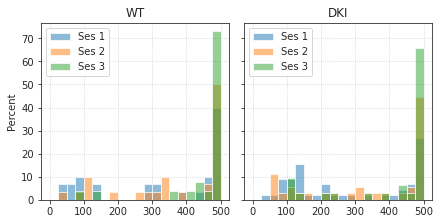

In [8]:
fig, axes = create_figure(1, 2, (6, 3), 'all', 'all', constrained_layout=True)

for ses in [1, 2 , 3]:
    sns.histplot(
        [x.shape[0] for x in wt[ses]],
        color=f'C{ses - 1}',
        bins=np.linspace(0, 500, 21),
        label=f'Ses {ses}',
        stat='percent',
        alpha=0.5,
        ax=axes[0],
    )
    sns.histplot(
        [x.shape[0] for x in dki[ses]],
        color=f'C{ses - 1}',
        bins=np.linspace(0, 500, 21),
        label=f'Ses {ses}',
        stat='percent',
        alpha=0.5,
        ax=axes[1],
    )
for ax in axes.flat:
    ax.legend()
    ax.grid()
axes[0].set_title('WT')
axes[1].set_title('DKI')
plt.show()

In [9]:
x = avg(wt[1][-1])
x /= np.nansum(x, -2, keepdims=True)
x.shape

(10, 2368)

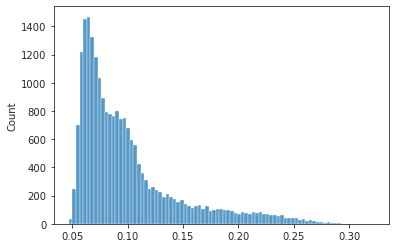

In [10]:
sns.histplot(x.ravel());

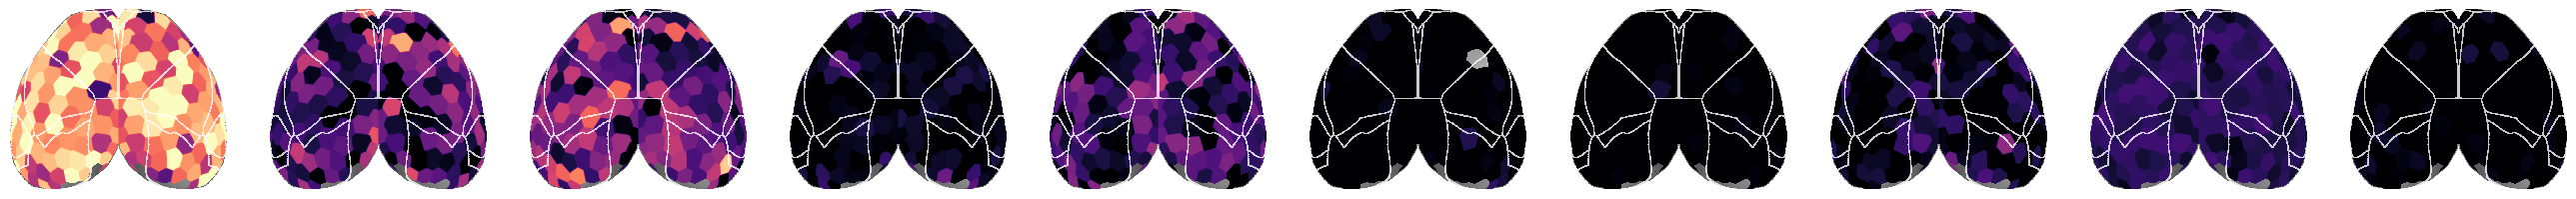

In [11]:
_ = bs.show(
    data=x,
    vmin=0.07,
    vmax=0.25,
    mask_thresh=0.05,
)

In [12]:
x = avg(wt[3][-1])
x /= np.nansum(x, -2, keepdims=True)
x.shape

(10, 2368)

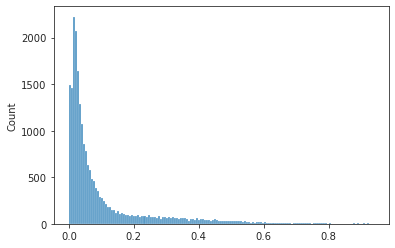

In [13]:
sns.histplot(x.ravel());

In [53]:
# wt = {k: np.concatenate(v) for k, v in wt.items()}
# dki = {k: np.concatenate(v) for k, v in dki.items()}

{k: v.shape for k, v in wt.items()}, {k: v.shape for k, v in dki.items()}

(
    {
        1: (9998, 10, 2368),
        2: (11273, 10, 2368),
        3: (11843, 10, 2368),
        5: (11323, 10, 2368),
        6: (6956, 10, 2368)
    },
    {
        1: (12922, 10, 2368),
        2: (12624, 10, 2368),
        3: (13447, 10, 2368),
        5: (24506, 10, 2368),
        6: (21175, 10, 2368)
    }
)

#### Group results

In [14]:
%%time

pi_all = do_group_tmp(wt, [1, 2, 3])
pi = avg(pi_all)
pi_all.shape, pi.shape

CPU times: user 2h 4min 43s, sys: 1min 6s, total: 2h 5min 49s
Wall time: 4min 38s


((33114, 10, 2368), (10, 2368))

In [15]:
pi_brn = np_nans((num_k, *brn.shape))
for oc, _x in enumerate(pi):
    for i, n in i2n.items():
        pi_brn[oc].flat[region_idxs[i]] = _x[n]

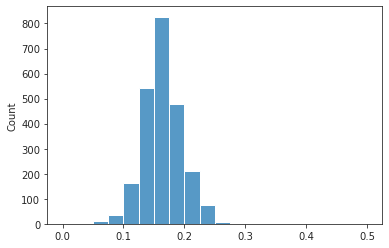

In [19]:
oc = 6
sns.histplot(pi[oc], bins=np.linspace(0, 0.5, 21));

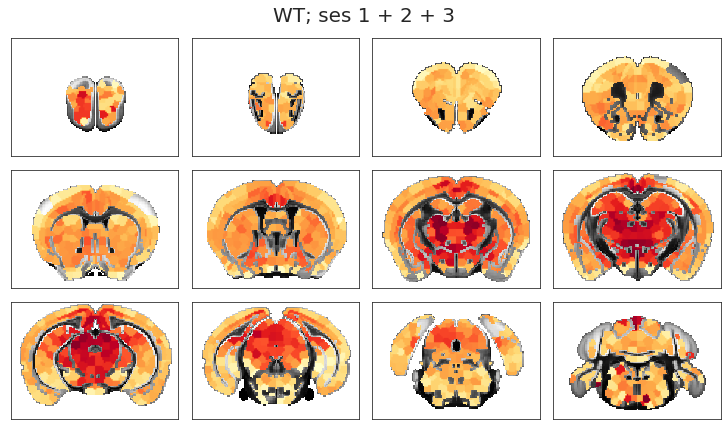

In [25]:
slices = range(10, 111, 9)

thres = 0.1
vmin = 0.1
vmax = 0.25
interp = 'antialiased'

fig, axes = create_figure(3, 4, (10, 5.45), 'all', 'all', constrained_layout=True)
for i, s_ in enumerate(slices):
    ax = axes.flat[i]
    ax.imshow(mwh(~root[s_], template[s_]), cmap='Greys_r')
    x2p = pi_brn[oc][s_]
    x2p = mwh(x2p < thres, x2p)
    ax.imshow(x2p, cmap='YlOrRd', vmin=vmin, vmax=vmax, interpolation=interp)
fig.suptitle(f"WT; ses 1 + 2 + 3", fontsize=20, y=1.07)
remove_ticks(axes, False)
plt.show()

## Session level

In [28]:
wt = collections.defaultdict(list)
dki = collections.defaultdict(list)
for k in keys:
    g, s, ses, run = decode_key(k)
    if ses is None or run is not None:
        continue
    sv = SVINET(key=k, **kwargs).load_results()

    if g == 'WT':
        wt[ses].append(sv.gam_all)
    elif g == 'DKI':
        dki[ses].append(sv.gam_all)
    else:
        raise ValueError

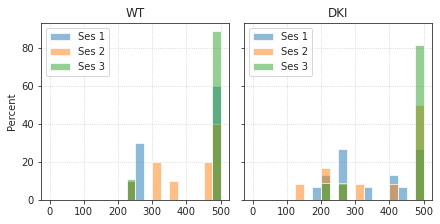

In [30]:
fig, axes = create_figure(1, 2, (6, 3), 'all', 'all', constrained_layout=True)

for ses in [1, 2 , 3]:
    sns.histplot(
        [x.shape[0] for x in wt[ses]],
        color=f'C{ses - 1}',
        bins=np.linspace(0, 500, 21),
        label=f'Ses {ses}',
        stat='percent',
        alpha=0.5,
        ax=axes[0],
    )
    sns.histplot(
        [x.shape[0] for x in dki[ses]],
        color=f'C{ses - 1}',
        bins=np.linspace(0, 500, 21),
        label=f'Ses {ses}',
        stat='percent',
        alpha=0.5,
        ax=axes[1],
    )
for ax in axes.flat:
    ax.legend()
    ax.grid()
axes[0].set_title('WT')
axes[1].set_title('DKI')
plt.show()

#### Group results

In [39]:
%%time

pi_all = do_group_tmp(wt, [1, 2, 3])
pi = avg(pi_all)
pi_all.shape, pi.shape

CPU times: user 56min 29s, sys: 36.2 s, total: 57min 6s
Wall time: 2min 4s


((12280, 10, 2368), (10, 2368))

In [40]:
pi_brn = np_nans((num_k, *brn.shape))
for oc, _x in enumerate(pi):
    for i, n in i2n.items():
        pi_brn[oc].flat[region_idxs[i]] = _x[n]

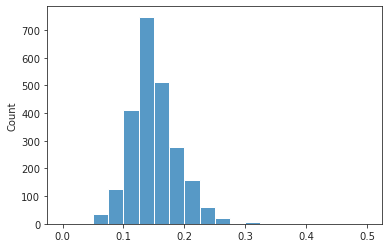

In [63]:
oc = 8
sns.histplot(pi[oc], bins=np.linspace(0, 0.5, 21));

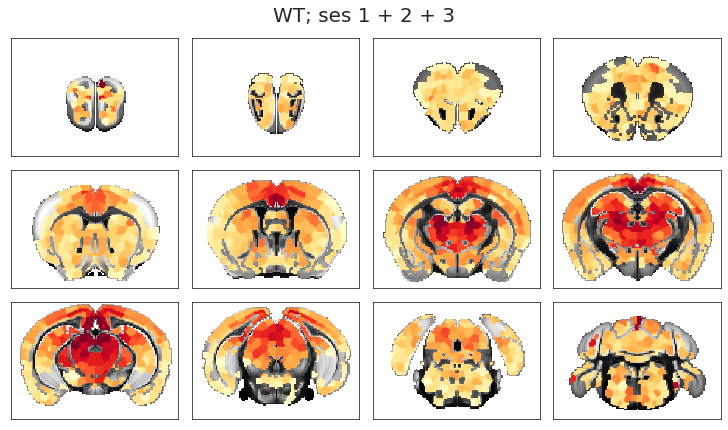

In [64]:
slices = range(10, 111, 9)

thres = 0.1
vmin = 0.1
vmax = 0.25
interp = 'antialiased'

fig, axes = create_figure(3, 4, (10, 5.45), 'all', 'all', constrained_layout=True)
for i, s_ in enumerate(slices):
    ax = axes.flat[i]
    ax.imshow(mwh(~root[s_], template[s_]), cmap='Greys_r')
    x2p = pi_brn[oc][s_]
    x2p = mwh(x2p < thres, x2p)
    ax.imshow(x2p, cmap='YlOrRd', vmin=vmin, vmax=vmax, interpolation=interp)
fig.suptitle(f"WT; ses 1 + 2 + 3", fontsize=20, y=1.07)
remove_ticks(axes, False)
plt.show()

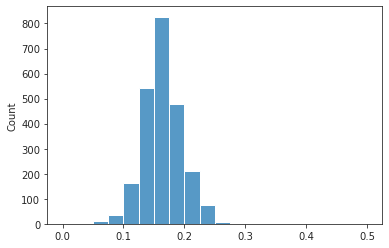

In [19]:
# Was run

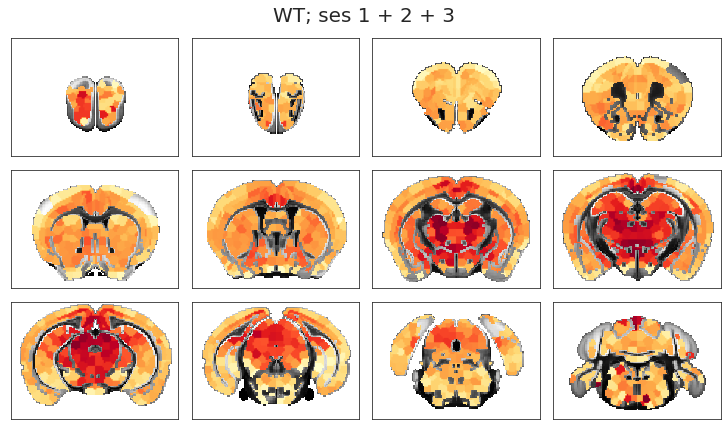

In [25]:
# Was run

## Now compare all WT vs all DKI (session level)

 Using ```correlation``` as match metric (prevopisly: ```cosine```)

In [8]:
wt = collections.defaultdict(list)
dki = collections.defaultdict(list)
for k in keys:
    g, s, ses, run = decode_key(k)
    if ses is None or run is not None:
        continue
    sv = SVINET(key=k, **kwargs).load_results()

    if g == 'WT':
        wt[ses].append(sv.gam_all)
    elif g == 'DKI':
        dki[ses].append(sv.gam_all)
    else:
        raise ValueError

In [9]:
%%time

pi_all_wt = do_group_tmp(wt, [1, 2, 3])
pi_all_dki = do_group_tmp(dki, [1, 2, 3])
pi_all_wt.shape, pi_all_dki.shape

CPU times: user 1h 49min 19s, sys: 1min 8s, total: 1h 50min 27s
Wall time: 4min


((12280, 10, 2368), (14670, 10, 2368))

In [10]:
pi_wt = avg(pi_all_wt)
pi_dki = avg(pi_all_dki)

good = np.logical_and(
    np.isnan(pi_wt).sum(0) == 0,
    np.isnan(pi_dki).sum(0) == 0,
)
print(f"non nan nodes: {good.sum()}")

non nan nodes: 2339

In [11]:
d = sp_dist.cdist(
    XA=pi_wt[:, good],
    XB=pi_dki[:, good],
    metric='cosine',
)
_, col_ind = sp_optim.linear_sum_assignment(d)
pi_dki = pi_dki[col_ind]
col_ind

array([0, 1, 2, 5, 9, 8, 3, 7, 4, 6])

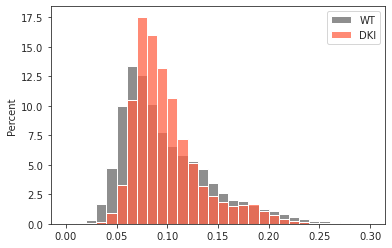

In [32]:
fig, ax = create_figure()
sns.histplot(
    pi_wt.ravel(),
    color='dimgrey',
    label='WT',
    stat='percent',
    bins=np.linspace(0, 0.3, 31),
    ax=ax,
)
sns.histplot(
    pi_dki.ravel(),
    color='tomato',
    label='DKI',
    stat='percent',
    bins=np.linspace(0, 0.3, 31),
    ax=ax,
)
ax.legend()
plt.show()

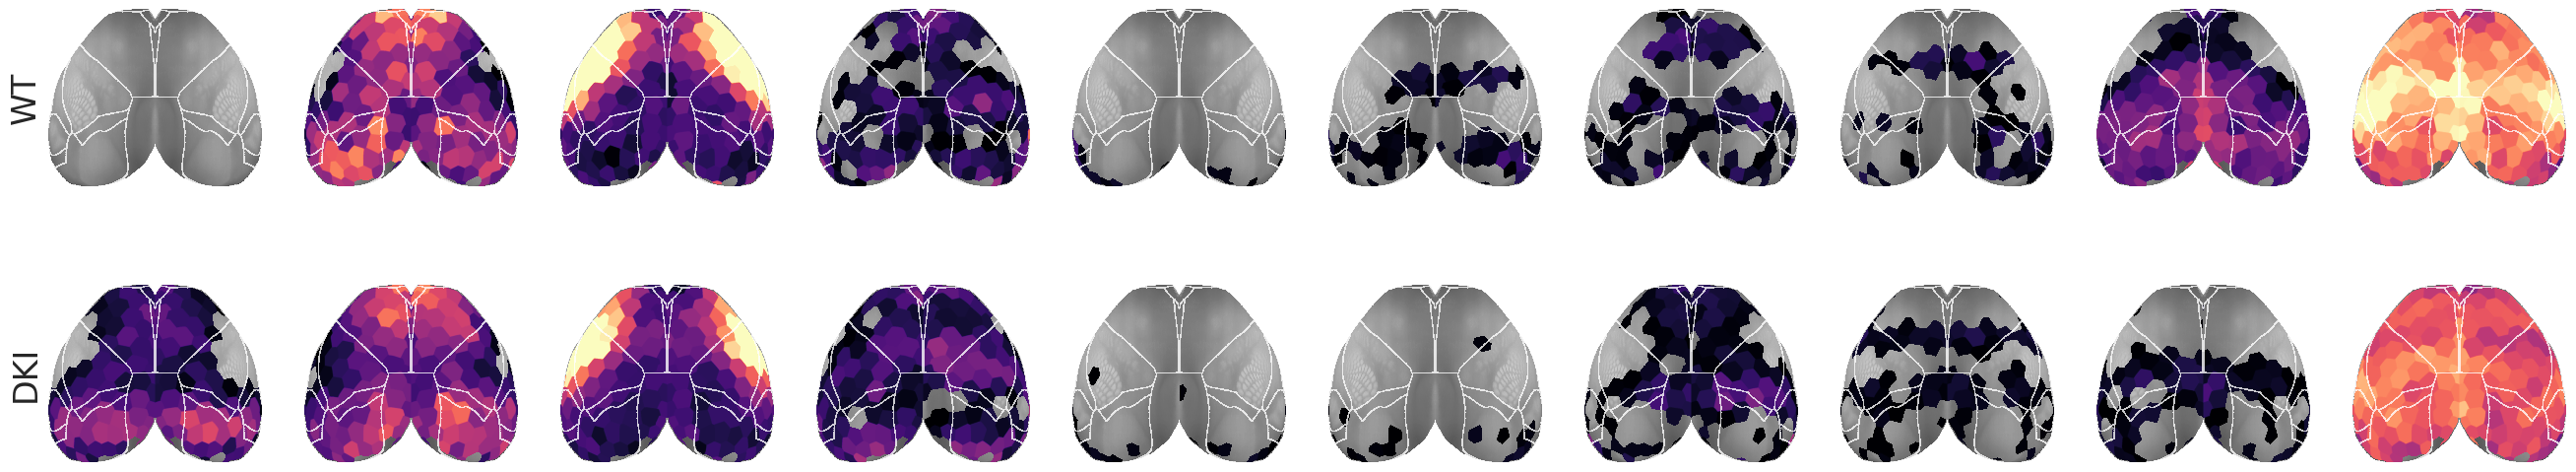

In [34]:
_ = bs.show(
    data={
        'WT': pi_wt,
        'DKI': pi_dki},
    vmin=0.07,
    vmax=0.25,
    mask_thresh=0.07,
    proj='top',
    contour=True,
)

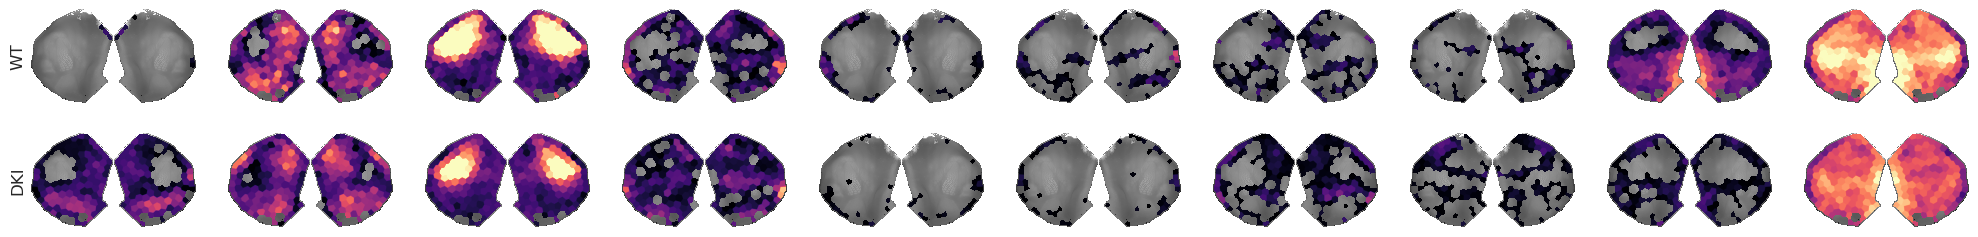

In [41]:
_ = bs.show(
    data={
        'WT': pi_wt,
        'DKI': pi_dki},
    vmin=0.07,
    vmax=0.25,
    mask_thresh=0.07,
    proj='flat',
    contour=False,
    figsize=(25, 3),
)

In [12]:
sim = 1 - sp_dist.cdist(
    XA=pi_wt[:, good],
    XB=pi_dki[:, good],
    metric='correlation',
) / 2

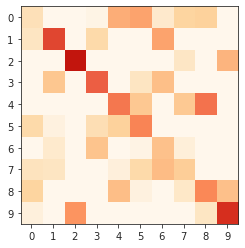

In [13]:
fig, ax = create_figure()
ax.imshow(sim, vmin=0.5, vmax=1, cmap='OrRd')
ax.locator_params(nbins=11)
plt.show()

In [14]:
pi_brn_wt = np_nans((num_k, *brn.shape))
pi_brn_dki = np_nans((num_k, *brn.shape))

for oc in range(num_k):
    for i, n in i2n.items():
        pi_brn_wt[oc].flat[region_idxs[i]] = pi_wt[oc, n]
        pi_brn_dki[oc].flat[region_idxs[i]] = pi_dki[oc, n]

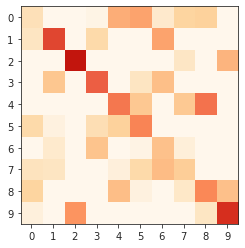

In [16]:
fig, ax = create_figure()
ax.imshow(sim, vmin=0.5, vmax=1, cmap='OrRd')
ax.locator_params(nbins=11)
plt.show()

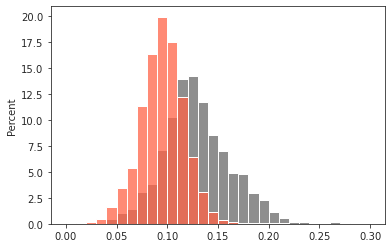

In [23]:
oc = 8
sns.histplot(pi_wt[oc], color='dimgrey', stat='percent', bins=np.linspace(0, 0.3, 31))
sns.histplot(pi_dki[oc], color='tomato', stat='percent', bins=np.linspace(0, 0.3, 31));

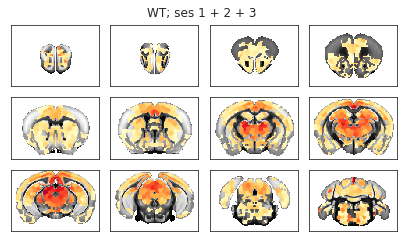

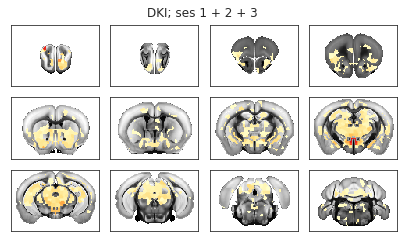

In [24]:
slices = range(10, 111, 9)

thres = 0.1
vmin = 0.1
vmax = 0.25
interp = 'antialiased'

fig, axes = create_figure(3, 4, (5.5, 3), 'all', 'all', constrained_layout=True)
for i, s_ in enumerate(slices):
    ax = axes.flat[i]
    ax.imshow(mwh(~root[s_], template[s_]), cmap='Greys_r')
    x2p = pi_brn_wt[oc][s_]
    x2p = mwh(x2p < thres, x2p)
    ax.imshow(x2p, cmap='YlOrRd', vmin=vmin, vmax=vmax, interpolation=interp)
fig.suptitle(f"WT; ses 1 + 2 + 3", fontsize=12, y=1.07)
remove_ticks(axes, False)
plt.show()


fig, axes = create_figure(3, 4, (5.5, 3), 'all', 'all', constrained_layout=True)
for i, s_ in enumerate(slices):
    ax = axes.flat[i]
    ax.imshow(mwh(~root[s_], template[s_]), cmap='Greys_r')
    x2p = pi_brn_dki[oc][s_]
    x2p = mwh(x2p < thres, x2p)
    ax.imshow(x2p, cmap='YlOrRd', vmin=vmin, vmax=vmax, interpolation=interp)
fig.suptitle(f"DKI; ses 1 + 2 + 3", fontsize=12, y=1.07)
remove_ticks(axes, False)
plt.show()

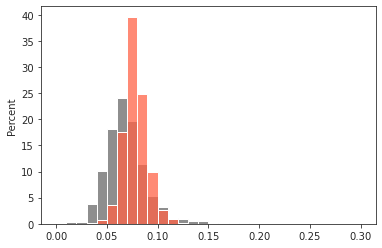

In [25]:
oc = 7
sns.histplot(pi_wt[oc], color='dimgrey', stat='percent', bins=np.linspace(0, 0.3, 31))
sns.histplot(pi_dki[oc], color='tomato', stat='percent', bins=np.linspace(0, 0.3, 31));

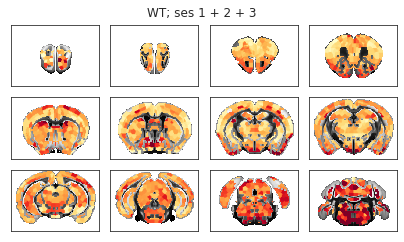

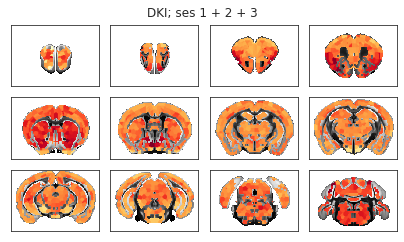

In [29]:
slices = range(10, 111, 9)

thres = 0.03
vmin = 0.03
vmax = 0.12
interp = 'antialiased'

fig, axes = create_figure(3, 4, (5.5, 3), 'all', 'all', constrained_layout=True)
for i, s_ in enumerate(slices):
    ax = axes.flat[i]
    ax.imshow(mwh(~root[s_], template[s_]), cmap='Greys_r')
    x2p = pi_brn_wt[oc][s_]
    x2p = mwh(x2p < thres, x2p)
    ax.imshow(x2p, cmap='YlOrRd', vmin=vmin, vmax=vmax, interpolation=interp)
fig.suptitle(f"WT; ses 1 + 2 + 3", fontsize=12, y=1.07)
remove_ticks(axes, False)
plt.show()


fig, axes = create_figure(3, 4, (5.5, 3), 'all', 'all', constrained_layout=True)
for i, s_ in enumerate(slices):
    ax = axes.flat[i]
    ax.imshow(mwh(~root[s_], template[s_]), cmap='Greys_r')
    x2p = pi_brn_dki[oc][s_]
    x2p = mwh(x2p < thres, x2p)
    ax.imshow(x2p, cmap='YlOrRd', vmin=vmin, vmax=vmax, interpolation=interp)
fig.suptitle(f"DKI; ses 1 + 2 + 3", fontsize=12, y=1.07)
remove_ticks(axes, False)
plt.show()

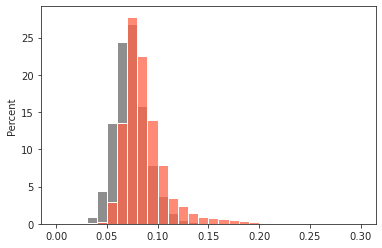

In [30]:
oc = 6
sns.histplot(pi_wt[oc], color='dimgrey', stat='percent', bins=np.linspace(0, 0.3, 31))
sns.histplot(pi_dki[oc], color='tomato', stat='percent', bins=np.linspace(0, 0.3, 31));

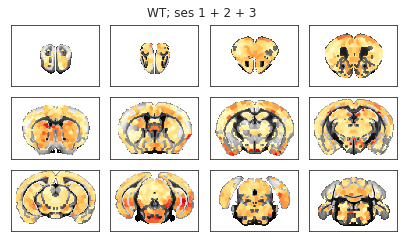

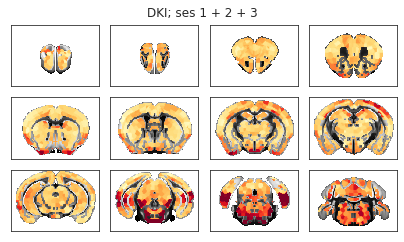

In [31]:
slices = range(10, 111, 9)

thres = 0.05
vmin = 0.05
vmax = 0.15
interp = 'antialiased'

fig, axes = create_figure(3, 4, (5.5, 3), 'all', 'all', constrained_layout=True)
for i, s_ in enumerate(slices):
    ax = axes.flat[i]
    ax.imshow(mwh(~root[s_], template[s_]), cmap='Greys_r')
    x2p = pi_brn_wt[oc][s_]
    x2p = mwh(x2p < thres, x2p)
    ax.imshow(x2p, cmap='YlOrRd', vmin=vmin, vmax=vmax, interpolation=interp)
fig.suptitle(f"WT; ses 1 + 2 + 3", fontsize=12, y=1.07)
remove_ticks(axes, False)
plt.show()


fig, axes = create_figure(3, 4, (5.5, 3), 'all', 'all', constrained_layout=True)
for i, s_ in enumerate(slices):
    ax = axes.flat[i]
    ax.imshow(mwh(~root[s_], template[s_]), cmap='Greys_r')
    x2p = pi_brn_dki[oc][s_]
    x2p = mwh(x2p < thres, x2p)
    ax.imshow(x2p, cmap='YlOrRd', vmin=vmin, vmax=vmax, interpolation=interp)
fig.suptitle(f"DKI; ses 1 + 2 + 3", fontsize=12, y=1.07)
remove_ticks(axes, False)
plt.show()

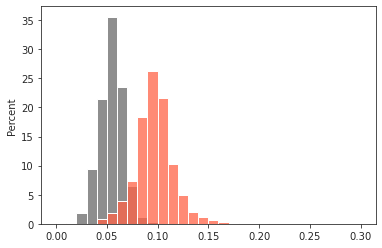

In [35]:
oc = 0
sns.histplot(pi_wt[oc], color='dimgrey', stat='percent', bins=np.linspace(0, 0.3, 31))
sns.histplot(pi_dki[oc], color='tomato', stat='percent', bins=np.linspace(0, 0.3, 31));

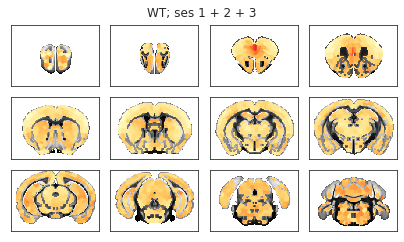

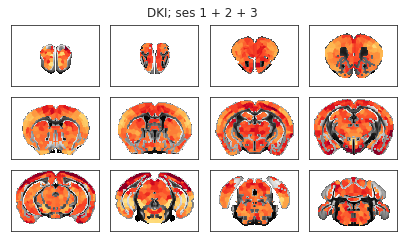

In [36]:
slices = range(10, 111, 9)

thres = 0.02
vmin = 0.02
vmax = 0.15
interp = 'antialiased'

fig, axes = create_figure(3, 4, (5.5, 3), 'all', 'all', constrained_layout=True)
for i, s_ in enumerate(slices):
    ax = axes.flat[i]
    ax.imshow(mwh(~root[s_], template[s_]), cmap='Greys_r')
    x2p = pi_brn_wt[oc][s_]
    x2p = mwh(x2p < thres, x2p)
    ax.imshow(x2p, cmap='YlOrRd', vmin=vmin, vmax=vmax, interpolation=interp)
fig.suptitle(f"WT; ses 1 + 2 + 3", fontsize=12, y=1.07)
remove_ticks(axes, False)
plt.show()


fig, axes = create_figure(3, 4, (5.5, 3), 'all', 'all', constrained_layout=True)
for i, s_ in enumerate(slices):
    ax = axes.flat[i]
    ax.imshow(mwh(~root[s_], template[s_]), cmap='Greys_r')
    x2p = pi_brn_dki[oc][s_]
    x2p = mwh(x2p < thres, x2p)
    ax.imshow(x2p, cmap='YlOrRd', vmin=vmin, vmax=vmax, interpolation=interp)
fig.suptitle(f"DKI; ses 1 + 2 + 3", fontsize=12, y=1.07)
remove_ticks(axes, False)
plt.show()

## Conclusion: for now use session level

Now running the following:

```bash
time ./loop_svinet.sh 128 3 7 p10-sample 500 bold rest “0.008,0.28” pearson “sub-[0-9A-Z]*_ses-[1-9]”
```

In [16]:
cnt = []
for f in sorted(os.listdir(mice.cfg.svinet_dir)):
    files = pjoin(mice.cfg.svinet_dir, f, 'real', 'p10-sample')
    files = sorted(os.listdir(files))
    cnt.append(len(files) - 1)
cnt = collections.Counter(cnt)
cnt

Counter({0: 419, 500: 118})